In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap

# Loading the dataset
from google.colab import files
uploaded = files.upload()

# Reading the dataset into a DataFrame
data = pd.read_csv("employee_productivity.csv")
data.head()

Saving employee_productivity.csv to employee_productivity (1).csv


,Experience,Training_Hours,Work_Life_Balance,Team_Dynamics,Environment_Score,Role,Team_ID,Productivity_Score
0,6,55.1,4,8.0,4.7,Engineer,12,315.1
1,19,48.7,3,7.4,9.1,Analyst,2,400.8
2,28,54.1,4,6.3,6.4,Engineer,11,417.4
3,14,54.2,3,9.1,6.2,Technician,14,342.1
4,10,13.2,3,6.2,6.0,Engineer,16,210.9


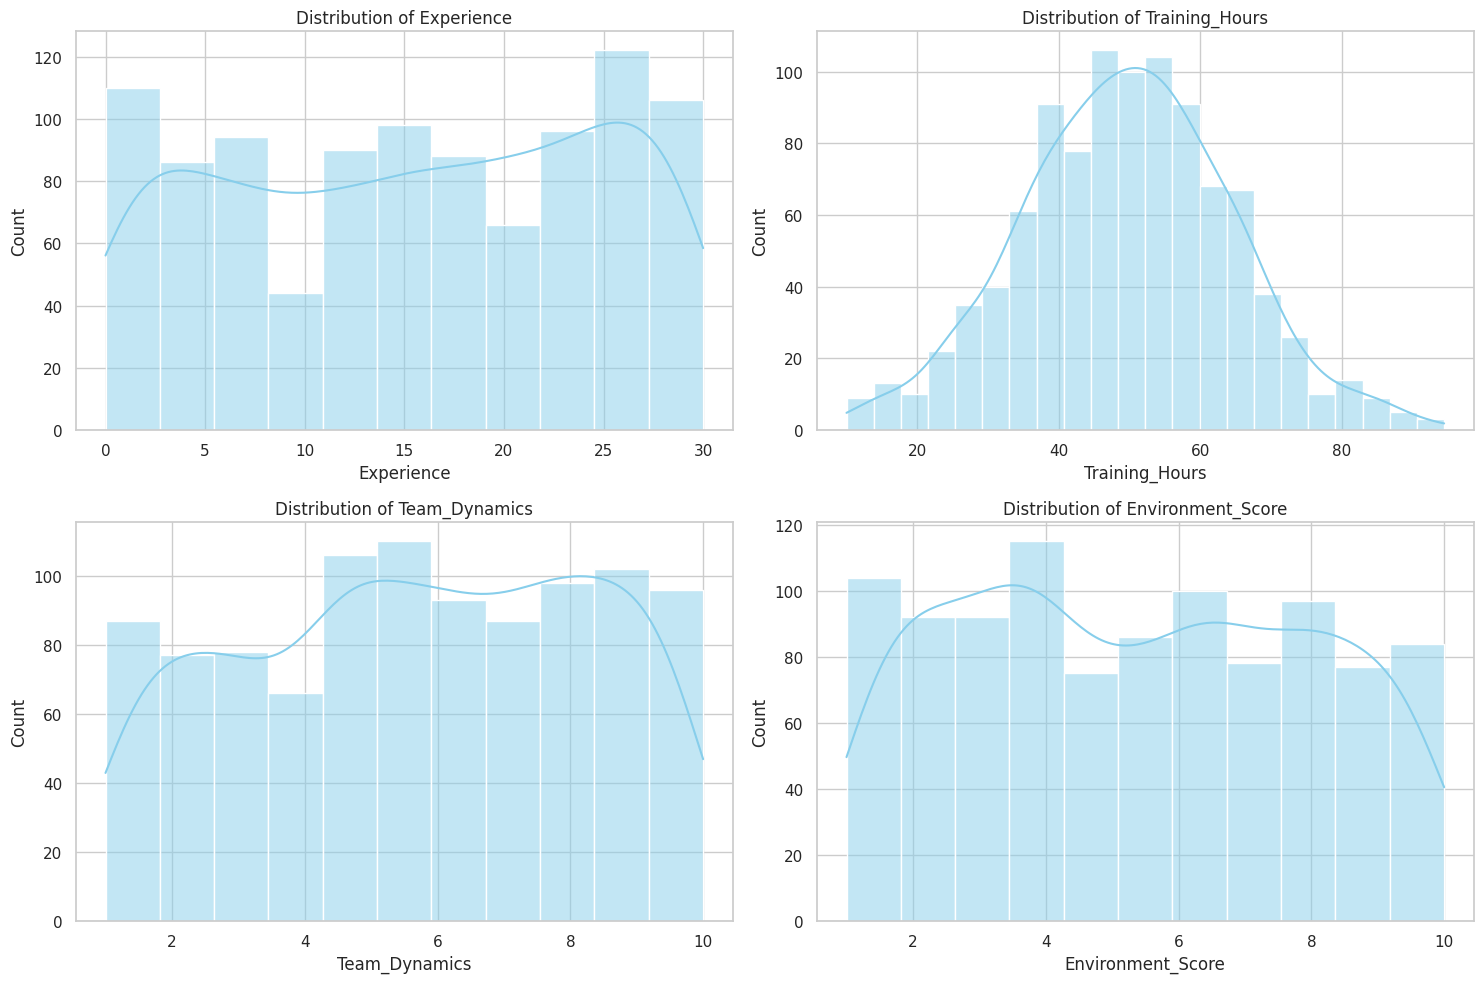

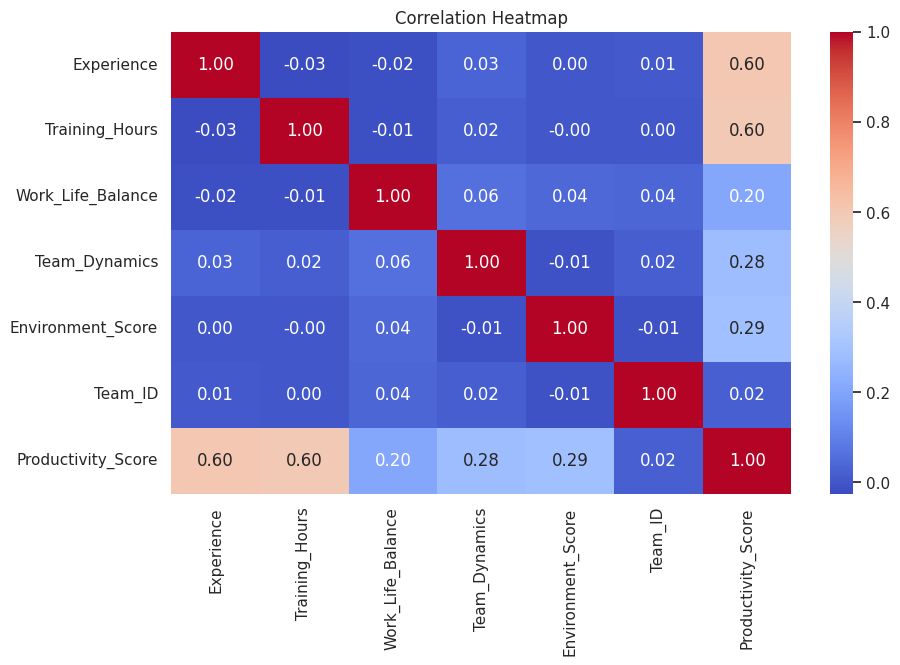

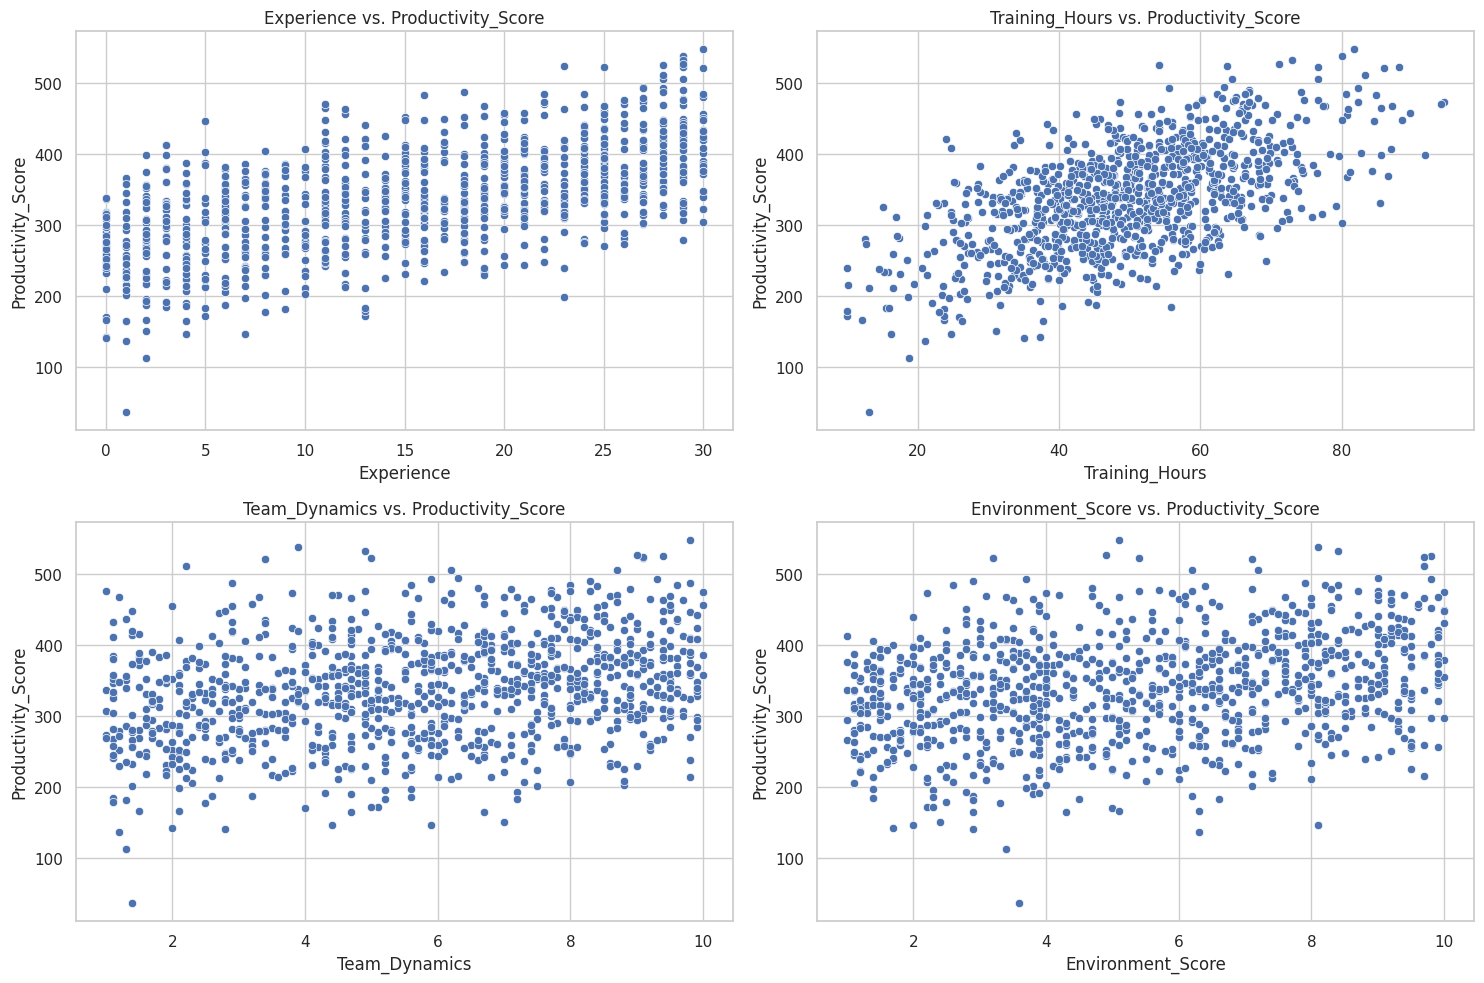

In [5]:
# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# 1. Plot distributions of continuous features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
continuous_features = ['Experience', 'Training_Hours', 'Team_Dynamics', 'Environment_Score']

for i, feature in enumerate(continuous_features):
    sns.histplot(data[feature], kde=True, ax=axes[i // 2, i % 2], color="skyblue")
    axes[i // 2, i % 2].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

# 2. Correlation Heatmap (fixed to include only numeric data)
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# 3. Scatterplots for relationships between continuous features and the target
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, feature in enumerate(continuous_features):
    sns.scatterplot(x=data[feature], y=data['Productivity_Score'], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"{feature} vs. Productivity_Score")
    axes[i // 2, i % 2].set_xlabel(feature)
    axes[i // 2, i % 2].set_ylabel("Productivity_Score")
plt.tight_layout()
plt.show()



In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define columns for preprocessing
continuous_features = ['Experience', 'Training_Hours', 'Team_Dynamics', 'Environment_Score']
categorical_features = ['Role']

# Standardize continuous features
scaler = StandardScaler()

# One-hot encode categorical features
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated to use 'sparse_output'

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, continuous_features),
        ('cat', one_hot_encoder, categorical_features)
    ]
)

# Apply preprocessing to the dataset
processed_data = preprocessor.fit_transform(data)

# Extract feature names
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_feature_names = continuous_features + list(one_hot_feature_names)

# Create a DataFrame for processed data
processed_df = pd.DataFrame(processed_data, columns=processed_feature_names)

# Add the target variable
processed_df['Productivity_Score'] = data['Productivity_Score']

# Create interaction terms
processed_df['Experience_x_Training'] = processed_df['Experience'] * processed_df['Training_Hours']

# Display the processed DataFrame
processed_df.head()


,Experience,Training_Hours,Team_Dynamics,Environment_Score,Role_Clerk,Role_Engineer,Role_Manager,Role_Technician,Productivity_Score,Experience_x_Training
0,-1.022585,0.368141,0.900474,-0.245808,0.0,1.0,0.0,0.0,315.1,-0.376455
1,0.384443,-0.061452,0.666878,1.447029,0.0,0.0,0.0,0.0,400.8,-0.023625
2,1.358539,0.301017,0.238618,0.408243,0.0,1.0,0.0,0.0,417.4,0.408944
3,-0.156721,0.307730,1.328733,0.331296,0.0,0.0,0.0,1.0,342.1,-0.048228
4,-0.589653,-2.444351,0.199686,0.254349,0.0,1.0,0.0,0.0,210.9,1.441319


In [8]:
# Define features and target
X = processed_df.drop(columns=['Productivity_Score'])
y = processed_df['Productivity_Score']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes of splits
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")


Training set: (700, 9)
Validation set: (150, 9)
Testing set: (150, 9)


In [9]:
# Initialize the MLP Regressor
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=500,
    random_state=42
)

# Train the model
mlp_model.fit(X_train, y_train)

# Predict on validation data
y_val_pred = mlp_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")


Validation MSE: 883.3971234083102
Validation MAE: 23.74580838271626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# Predict on test data
y_test_pred = mlp_model.predict(X_test)

# Evaluate on test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Compare with simpler models (e.g., Linear Regression)
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_test_pred_linear = linear_model.predict(X_test)

linear_test_mse = mean_squared_error(y_test, y_test_pred_linear)
linear_test_mae = mean_absolute_error(y_test, y_test_pred_linear)

print(f"Linear Regression Test MSE: {linear_test_mse}")
print(f"Linear Regression Test MAE: {linear_test_mae}")


Test MSE: 807.7865115194348
Test MAE: 22.121391817660527
Linear Regression Test MSE: 610.3212719981524
Linear Regression Test MAE: 19.759860483483347
